# Squeezed Lasing

In [501]:
from qutip import *
import math as math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy as scipy
import matplotlib.animation as animation
from tqdm import tqdm
import sys
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import os

## Definition of parameters

### Bare parameters

In [502]:
N = 50 # Dimension of the Hilbert space of the cavity
g_0 = 1 # light-matter coupling
n_q = 50 # Photon saturation number
C = np.linspace(1e-15,2,100) # Cooperativity (equal to the pumping parameter p)
k = g_0*np.sqrt(2/(C*n_q)) # Photon decay rate
P = 2*n_q*k # Incoherent pumping
eta = np.zeros(np.size(C)) # Photon loss due to other decay channels
omega_p = 1 # Amplitude of the coherent drive (down-conversion)
delta_c = 1 # Detuning w_c-w_p
delta_sigma = 1 # Detuning w_sigma-w_p

### Squeezed parameters

In [503]:
r = 1 # Squeezing parameter
theta = np.pi # Squeezing angle
delta_s = delta_c*np.sqrt(1-(omega_p/delta_c)**2) # Detuning in the squeezed basis
C_s = C*np.cosh(r)**2 # Squeezed cooperativity (equal to the squeezed pumping parameter p_s)

Check RWA condition $\Delta_\sigma, \Delta_s >> g\sinh{r}$

In [504]:
aux = 2

if delta_sigma > aux*g_0*np.sinh(r):
    if delta_s > aux*g_0*np.sinh(r):
        print('double check')
    else:
        print('Check values of delta_c and omega_p')
else:
    print('Check values of delta_c and omega_p')
print(g_0*np.sinh(r))

Check values of delta_c and omega_p
1.1752011936438014


## Definition of operators

### Gain medium (1 atom $\rightarrow$ two-level system)

In [505]:
g = basis(2,0) # Ground state
e = basis(2,1) # Excited state
sigma = tensor(identity(N),g*e.dag()) # Lowering operator

### Annihilation operator in the squeezed basis $\hat{a}_s$

In [506]:
a_s = tensor(destroy(N),identity(2))

### Annihilation operator in the bare basis $\hat{a}$

In [507]:
a = a_s*np.cosh(r)-np.exp(-1j*theta)*a_s.dag()*np.sinh(r)

### Squeezing operator $S(\xi)$

In [508]:
chi = r*np.exp(-1j*theta) 
S = (0.5*(chi*a*a-np.conj(chi)*a.dag()*a.dag())).expm() # Squeezing operator

### Hamiltonian in the squeezed basis

In [509]:
H = delta_s*a_s.dag()*a_s+delta_sigma*sigma.dag()*sigma+g_0*np.cosh(r)*(a_s.dag()*sigma+a_s*sigma.dag())

## Stationary state of the system

### Solving the master equation for $\rho_s$ and different values of $C$

In [510]:
result = [] # Steady states of the system in the squeezed basis

for i in tqdm(range(np.size(C))):    
    coll1 = np.sqrt(P[i])*sigma.dag() # Collapse operator for incoherent pumping
    coll2 = np.sqrt(k[i]*(1+eta[i]))*a_s # Collapse operator for photon decay
    result.append(steadystate(H, [coll1,coll2]))

100%|██████████| 100/100 [00:01<00:00, 62.43it/s]


### Return to bare basis $\rho$

In [511]:
bare_rho = S*result*S.dag() # Steady states in the bare basis

### Photon population and lasing threshold

In [512]:
n_s = np.zeros(np.size(C)) # Photon population in the squeezed basis

for i in range(np.size(C)):   
    n_s[i] = expect(a_s.dag()*a_s,result[i])

#### Mean-field solution

In [513]:
mfs = np.heaviside(C_s-1,0)*n_q*(1-1/C_s)*np.cosh(2*r)+np.sinh(r)**2 # Mean-field solution

#### Photon population in the bare basis

In [514]:
n = n_s*np.cosh(2*r)+np.sinh(r)**2 # Photon population

Check that $\langle \hat{a}_s^2\rangle$ and $\langle\hat{a}_s^{\dag 2}\rangle$ are zero

In [515]:
exp_as = np.zeros(np.size(C),dtype=np.complex_) # Expected value of a_s^2
exp_asd = np.zeros(np.size(C),dtype=np.complex_) # Expected value of a_s.dag^2
for i in range(np.size(C)):   
    exp_as[i] = expect(a_s**2,result[i])
    exp_asd[i] = expect(a_s.dag()**2,result[i])
print(np.sum(exp_as+exp_asd))

0j


#### Plot photon number $n$ against $C$

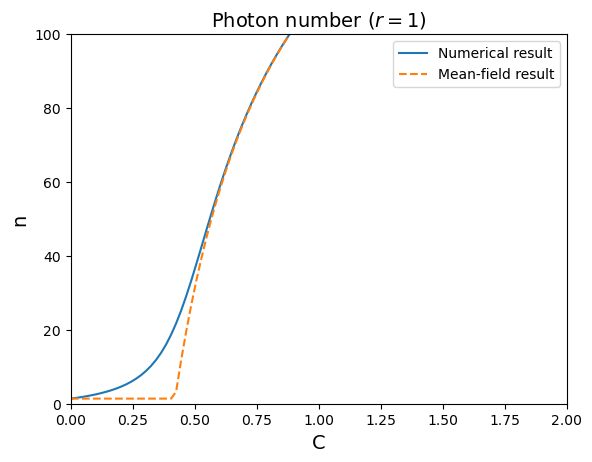

In [516]:
plt.plot(C,n,label='Numerical result')
plt.plot(C,mfs,'--', label='Mean-field result')
plt.xlim([np.min(C),np.max(C)])
plt.ylim([0,2*n_q])
plt.title('Photon number ($r=$'+str(r)+')',fontsize=14)
plt.xlabel('C',fontsize=14)
plt.ylabel('n',fontsize=14)
plt.legend()

<div class="alert alert-block alert-info"> 
<b>Note: </b>From this point onwards the cooperativity value is chosen always to be 1.

### Wigner function of the phase-diffused steady-state

In [517]:
wig_xvec = np.linspace(-25,25,100) # Values of x in the phase space
wig_pvec = np.linspace(-10,10,100) # Values of p in the phase space (squeezed quadrature)
index = 50 # Index of the cooperativity value
Wigner = wigner(bare_rho[index].ptrace(0),wig_xvec,wig_pvec) # Calculation of the Wigner function for C[index]

Text(0, 0.5, 'p')

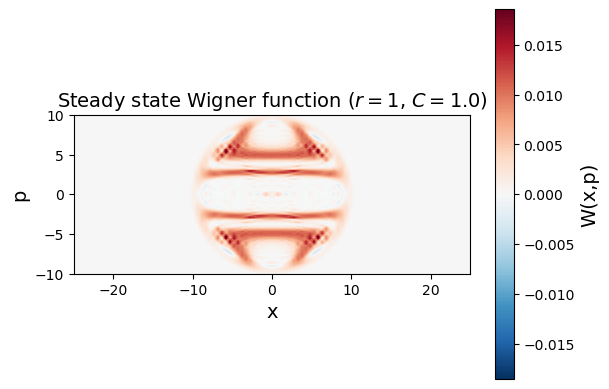

In [518]:
nrm = mpl.colors.Normalize(-Wigner.max(),Wigner.max()) # Colorbar settings
cbar = plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.RdBu_r))
cbar.set_label('W(x,p)',fontsize=14)

plt.contourf(wig_xvec, wig_pvec, Wigner, 100, cmap=cm.RdBu_r, norm=nrm) # Plot of the Wigner

plt.xlim([np.min(wig_xvec),np.max(wig_xvec)]) # Figure settings
plt.ylim([np.min(wig_pvec),np.max(wig_pvec)])
plt.title('Steady state Wigner function ($r=$'+str(r)+', $C=$'+str(format(C[index],'.1f'))+')',fontsize=14)
plt.axis('scaled')
plt.xlabel('x',fontsize=14)
plt.ylabel('p',fontsize=14)

## Emission spectrum $S(\omega)$

### Time vector in terms of the cavity caracteristic decay time $\kappa$

In [519]:
tau_vec = np.linspace(0,10/k[index],5000) # Time vector of delays

### Collapse operators for parameters corresponding to $C=1$

In [520]:
coll1_C = np.sqrt(P[index])*sigma.dag() # Collapse operator for incoherent pumping
coll2_C = np.sqrt(k[index]*(1+eta[index]))*a_s # Collapse operator for photon decay

### Computation of the emission spectrum

In [521]:
wlist = np.linspace(0,1,50)/(2*np.pi)
spec = spectrum(H, wlist, [coll1_C,coll2_C], a.dag(), a, solver='pi')

MemoryError: Unable to allocate 1.49 GiB for an array with shape (10000, 10000) and data type complex128

In [460]:
corr = correlation_2op_1t(H, None, tau_vec, [coll1_C,coll2_C], a.dag(), a)
wlist, spec = spectrum_correlation_fft(tau_vec,corr)

In [461]:
check = np.zeros(np.size(tau_vec))
for i in range(np.size(tau_vec)):
    check[i] = np.abs(spec[i])-np.abs(spec[-i])

(-0.75, 0.75)

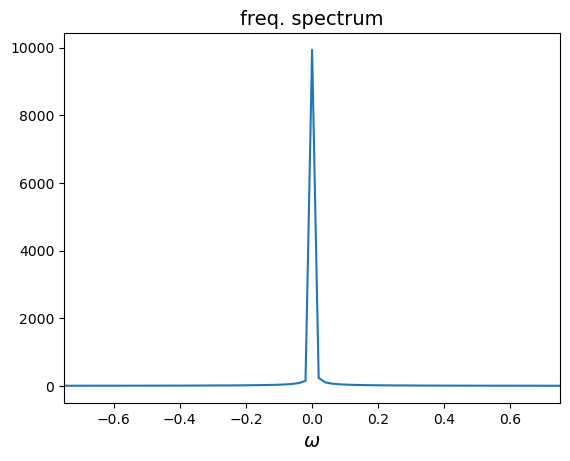

In [462]:
plt.plot(wlist/(2*np.pi),abs(spec))
plt.title('freq. spectrum',fontsize=14)
plt.xlabel('$\omega$',fontsize=14)
plt.xlim([-0.75,0.75])

In [500]:
L = [] # Liouvillian
vp = [] # Eigenvalues of the Liouvillian
for i in tqdm(range(np.size(C))):   
    L.append(liouvillian(H, [coll1_C,coll2_C]))
    vp.append(L[i].eigenenergies())

  0%|          | 0/100 [00:00<?, ?it/s]


MemoryError: Unable to allocate 23.8 GiB for an array with shape (40000, 40000) and data type complex128

In [476]:
print(L[0])

Quantum object: dims = [[[350, 2], [350, 2]], [[350, 2], [350, 2]]], shape = (490000, 490000), type = super, isherm = False
Qobj data =
  (0, 0)	(-19.899748742132395+0j)
  (0, 1402)	(0.19899748742132392+0j)
  (1, 1)	(-9.949874371066198-1j)
  (1, 2)	-1.5430806348152437j
  (1, 1403)	(0.19899748742132392+0j)
  (2, 1)	-1.5430806348152437j
  (2, 2)	(-19.999247485843057+0j)
  (2, 1404)	(0.28142494558940573+0j)
  (3, 3)	(-10.04937311477686-1j)
  (3, 4)	-2.182245561591003j
  (3, 1405)	(0.28142494558940573+0j)
  (4, 3)	-2.182245561591003j
  (4, 4)	(-20.09874622955372+0j)
  (4, 1406)	(0.3446737587922816+0j)
  (5, 5)	(-10.14887185848752-1j)
  (5, 6)	-2.6726940596756386j
  (5, 1407)	(0.3446737587922816+0j)
  (6, 5)	-2.6726940596756386j
  (6, 6)	(-20.19824497326438+0j)
  (6, 1408)	(0.39799497484264784+0j)
  (7, 7)	(-10.248370602198184-1j)
  (7, 8)	-3.0861612696304874j
  (7, 1409)	(0.39799497484264784+0j)
  (8, 7)	-3.0861612696304874j
  (8, 8)	(-20.29774371697504+0j)
  :	:
  (489989, 489990)	-28.661

### Secord order coherence function $g^{(2)}(\tau)$

In [409]:
corr2 = correlation_3op_1t(H, None, tvec, [coll1,coll2], a_s.dag(), a_s.dag()*a_s, a_s)
n_corr = mesolve(H, result[index], tvec, [coll1,coll2], [a_s.dag()*a_s]).expect[0]
corr_2f = corr2/(n_corr[0]*n_corr[np.size(tvec)-1])

c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Second order coherence function')

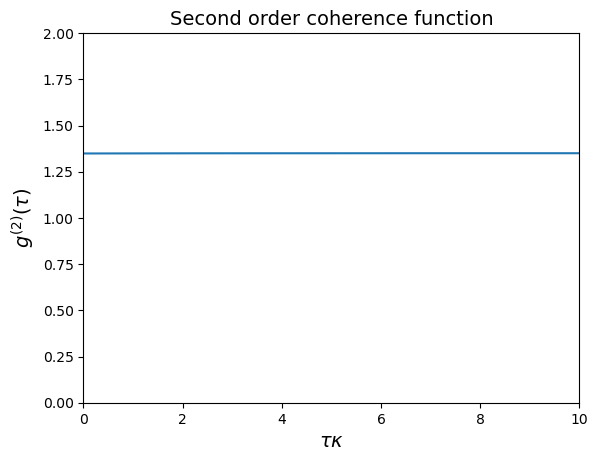

In [413]:
plt.plot(tvec*k[index],corr_2f)
plt.ylim([0,2])
plt.xlim(min(tvec*k[index]),max(tvec*k[index]))
plt.xlabel(r'$\tau\kappa$',fontsize=14)
plt.ylabel(r'$g^{(2)}(\tau)$',fontsize=14)
plt.title('Second order coherence function',fontsize=14)

## More things (to be done...)
- Symmetry broken solutions
- Squeezed spectrum
- Relation between $\eta$ and $N_s$